# Preliminary 
Here we set the device and then the hyperparams.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torchlens

if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

# Data Loader Function

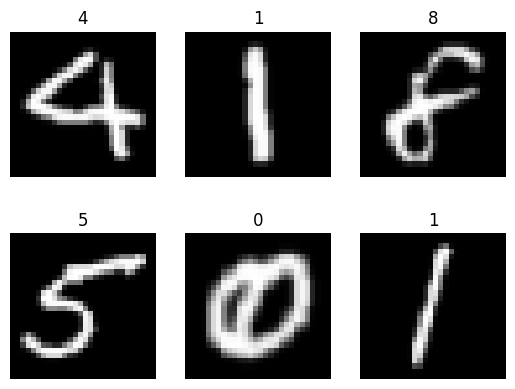

In [2]:
def load_data(batch_size):
    digit_data = np.load('digits.npz')
    inputs = digit_data['inputs']
    labels = digit_data['labels']

    # Split the data into train, validation, and test sets
    train_images, temp_images, train_labels, temp_labels = train_test_split(inputs, labels, test_size=0.5, stratify=labels)
    val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.6, stratify=temp_labels)

    # Convert to tensors
    train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0
    train_labels = torch.tensor(train_labels)
    val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1) / 255.0
    val_labels = torch.tensor(val_labels)
    test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0
    test_labels = torch.tensor(test_labels)

    # transform data by rotating and flipping
    transform = transforms.Compose(
        [
            transforms.RandomRotation((90, 90)),
            transforms.RandomVerticalFlip(1),
        ]
    )

    # apply transforms to the training data
    train_images_transformed = transform(train_images)
    val_images_transformed = transform(val_images)
    test_images_transformed = transform(test_images)

    train_dataset = torch.utils.data.TensorDataset(train_images_transformed, train_labels)
    val_dataset = torch.utils.data.TensorDataset(val_images_transformed, val_labels)
    test_dataset = torch.utils.data.TensorDataset(test_images_transformed, test_labels)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset, batch_size=batch_size, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False
    )

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data(6)

# visualize some of the data
examples = iter(train_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.title(example_targets[i].item())
    plt.axis("off")
    plt.imshow(example_data[i][0], cmap="gray")

# Early Stopping Class

In [3]:
# early_stopping.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Example CNN Class

In [4]:
# An example CNN model
class ExampleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ExampleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=4)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=4)
        self.fc1 = nn.Linear(16 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = nn.ReLU()(out)
        out = nn.MaxPool2d(2)(out)
        out = self.conv2(out)
        out = nn.ReLU()(out)
        out = nn.MaxPool2d(2)(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = nn.ReLU()(out)
        out = self.fc2(out)
        return out

# Training Function

In [9]:
# train function
def train(model, model_name, train_loader, val_loader, num_epochs, learning_rate):

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=model_name)

    # save information per epoch and steps
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []

     # Training loop
    for epoch in range(num_epochs):
        
        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #capture loss
            train_losses.append(loss.item())

        # Validate the model
        model.eval()
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                output = model(val_images)
                loss = criterion(output, val_labels)
                valid_losses.append(loss.item())
        
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print training/validation statistics
        epoch_len = len(str(num_epochs))
            
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping!")
            break


# Evaluation Funciton

In [10]:
def evaluate(model, model_name, test_loader, learning_rate, batch_size, num_epochs):
    # Evaluate the model
    model.load_state_dict(torch.load(str(model_name), weights_only=True, map_location=device))

    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.title("Confusion Matrix (SOPCNN)")
    plt.show()

    # Model summary of accuracy and hyperparameters
    print(f"{model_name} Model Architecture:")
    print(model)
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))}")
    print("\nHyperparameters:")
    print(f"Learning Rate: {learning_rate}")
    print(f"Batch Size: {batch_size}")
    print(f"Number of Epochs: {num_epochs}")


In [11]:
# create model and hyperparams
smolcnn_model = ExampleCNN().to(device)
smolcnn_model_name = f'{smolcnn_model._get_name().lower()}.pt'

num_epochs = 1000
learning_rate = 0.001
batch_size = 256

train_loader, val_loader, test_loader = load_data(batch_size)
train(smolcnn_model, smolcnn_model_name, train_loader, test_loader, num_epochs, learning_rate)

100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


[   0/1000] train_loss: 2.30242 valid_loss: 2.27862
Validation loss decreased (inf --> 2.278617).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 135.22it/s]


[   1/1000] train_loss: 2.27759 valid_loss: 2.25774
Validation loss decreased (2.278617 --> 2.257739).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 105.12it/s]


[   2/1000] train_loss: 2.25237 valid_loss: 2.23260
Validation loss decreased (2.257739 --> 2.232597).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 116.54it/s]


[   3/1000] train_loss: 2.22335 valid_loss: 2.19951
Validation loss decreased (2.232597 --> 2.199506).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 164.35it/s]


[   4/1000] train_loss: 2.18709 valid_loss: 2.15670
Validation loss decreased (2.199506 --> 2.156700).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 172.12it/s]


[   5/1000] train_loss: 2.14151 valid_loss: 2.10078
Validation loss decreased (2.156700 --> 2.100779).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 139.94it/s]


[   6/1000] train_loss: 2.08486 valid_loss: 2.03310
Validation loss decreased (2.100779 --> 2.033099).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 199.13it/s]


[   7/1000] train_loss: 2.01384 valid_loss: 1.95099
Validation loss decreased (2.033099 --> 1.950990).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 169.31it/s]


[   8/1000] train_loss: 1.93189 valid_loss: 1.85425
Validation loss decreased (1.950990 --> 1.854248).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 192.59it/s]


[   9/1000] train_loss: 1.83265 valid_loss: 1.74328
Validation loss decreased (1.854248 --> 1.743278).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 156.76it/s]


[  10/1000] train_loss: 1.72044 valid_loss: 1.61850
Validation loss decreased (1.743278 --> 1.618501).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 185.84it/s]


[  11/1000] train_loss: 1.59287 valid_loss: 1.48085
Validation loss decreased (1.618501 --> 1.480848).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 180.78it/s]

[  12/1000] train_loss: 1.45692 valid_loss: 1.33531
Validation loss decreased (1.480848 --> 1.335311).  Saving model ...



100%|██████████| 2/2 [00:00<00:00, 182.74it/s]


[  13/1000] train_loss: 1.32201 valid_loss: 1.19591
Validation loss decreased (1.335311 --> 1.195914).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 169.81it/s]


[  14/1000] train_loss: 1.18511 valid_loss: 1.06353
Validation loss decreased (1.195914 --> 1.063529).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 136.36it/s]


[  15/1000] train_loss: 1.05632 valid_loss: 0.94380
Validation loss decreased (1.063529 --> 0.943798).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 166.29it/s]


[  16/1000] train_loss: 0.94894 valid_loss: 0.84425
Validation loss decreased (0.943798 --> 0.844247).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 170.22it/s]


[  17/1000] train_loss: 0.84632 valid_loss: 0.76003
Validation loss decreased (0.844247 --> 0.760030).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 182.98it/s]


[  18/1000] train_loss: 0.76460 valid_loss: 0.68961
Validation loss decreased (0.760030 --> 0.689615).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 168.62it/s]


[  19/1000] train_loss: 0.69659 valid_loss: 0.63575
Validation loss decreased (0.689615 --> 0.635751).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 132.55it/s]


[  20/1000] train_loss: 0.64071 valid_loss: 0.59825
Validation loss decreased (0.635751 --> 0.598255).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 179.84it/s]


[  21/1000] train_loss: 0.60413 valid_loss: 0.56460
Validation loss decreased (0.598255 --> 0.564600).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 134.15it/s]


[  22/1000] train_loss: 0.56419 valid_loss: 0.53350
Validation loss decreased (0.564600 --> 0.533497).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 187.78it/s]


[  23/1000] train_loss: 0.53007 valid_loss: 0.51080
Validation loss decreased (0.533497 --> 0.510797).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 186.19it/s]


[  24/1000] train_loss: 0.50227 valid_loss: 0.49513
Validation loss decreased (0.510797 --> 0.495127).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 191.86it/s]


[  25/1000] train_loss: 0.47978 valid_loss: 0.48853
Validation loss decreased (0.495127 --> 0.488525).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 181.08it/s]


[  26/1000] train_loss: 0.46292 valid_loss: 0.46841
Validation loss decreased (0.488525 --> 0.468410).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 155.41it/s]


[  27/1000] train_loss: 0.44370 valid_loss: 0.45498
Validation loss decreased (0.468410 --> 0.454983).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 186.40it/s]


[  28/1000] train_loss: 0.42438 valid_loss: 0.43587
Validation loss decreased (0.454983 --> 0.435875).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 136.73it/s]


[  29/1000] train_loss: 0.41091 valid_loss: 0.42831
Validation loss decreased (0.435875 --> 0.428311).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 197.14it/s]


[  30/1000] train_loss: 0.39597 valid_loss: 0.43115
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 150.70it/s]


[  31/1000] train_loss: 0.37858 valid_loss: 0.42689
Validation loss decreased (0.428311 --> 0.426886).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 188.77it/s]


[  32/1000] train_loss: 0.36672 valid_loss: 0.41272
Validation loss decreased (0.426886 --> 0.412722).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 163.48it/s]


[  33/1000] train_loss: 0.35781 valid_loss: 0.40545
Validation loss decreased (0.412722 --> 0.405445).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 179.92it/s]


[  34/1000] train_loss: 0.34475 valid_loss: 0.39501
Validation loss decreased (0.405445 --> 0.395005).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 176.88it/s]


[  35/1000] train_loss: 0.33650 valid_loss: 0.39836
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 174.90it/s]


[  36/1000] train_loss: 0.32358 valid_loss: 0.39609
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 186.05it/s]


[  37/1000] train_loss: 0.31075 valid_loss: 0.39102
Validation loss decreased (0.395005 --> 0.391023).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 147.05it/s]


[  38/1000] train_loss: 0.31109 valid_loss: 0.38911
Validation loss decreased (0.391023 --> 0.389113).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 79.82it/s]


[  39/1000] train_loss: 0.29232 valid_loss: 0.39001
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 104.26it/s]


[  40/1000] train_loss: 0.28795 valid_loss: 0.38997
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 167.55it/s]


[  41/1000] train_loss: 0.27966 valid_loss: 0.37916
Validation loss decreased (0.389113 --> 0.379161).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 132.21it/s]


[  42/1000] train_loss: 0.27161 valid_loss: 0.37736
Validation loss decreased (0.379161 --> 0.377359).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 201.29it/s]


[  43/1000] train_loss: 0.25905 valid_loss: 0.38456
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 170.84it/s]


[  44/1000] train_loss: 0.25902 valid_loss: 0.38020
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 213.13it/s]


[  45/1000] train_loss: 0.24920 valid_loss: 0.37929
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 172.26it/s]


[  46/1000] train_loss: 0.24045 valid_loss: 0.37230
Validation loss decreased (0.377359 --> 0.372304).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 213.06it/s]


[  47/1000] train_loss: 0.23012 valid_loss: 0.37352
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 189.27it/s]


[  48/1000] train_loss: 0.22471 valid_loss: 0.37738
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 231.16it/s]


[  49/1000] train_loss: 0.22462 valid_loss: 0.37987
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 236.80it/s]


[  50/1000] train_loss: 0.21071 valid_loss: 0.38150
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 182.90it/s]

[  51/1000] train_loss: 0.20592 valid_loss: 0.37119
Validation loss decreased (0.372304 --> 0.371193).  Saving model ...



100%|██████████| 2/2 [00:00<00:00, 211.50it/s]


[  52/1000] train_loss: 0.20513 valid_loss: 0.37302
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 179.98it/s]


[  53/1000] train_loss: 0.19260 valid_loss: 0.38200
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 208.77it/s]


[  54/1000] train_loss: 0.19019 valid_loss: 0.38705
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 162.54it/s]


[  55/1000] train_loss: 0.18325 valid_loss: 0.37696
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 191.39it/s]


[  56/1000] train_loss: 0.17768 valid_loss: 0.36981
Validation loss decreased (0.371193 --> 0.369808).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 144.63it/s]


[  57/1000] train_loss: 0.16875 valid_loss: 0.38027
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 171.63it/s]


[  58/1000] train_loss: 0.16332 valid_loss: 0.38884
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 135.90it/s]


[  59/1000] train_loss: 0.15891 valid_loss: 0.39350
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 172.58it/s]


[  60/1000] train_loss: 0.15474 valid_loss: 0.37874
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 144.91it/s]


[  61/1000] train_loss: 0.15226 valid_loss: 0.37146
EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 180.93it/s]


[  62/1000] train_loss: 0.14605 valid_loss: 0.38748
EarlyStopping counter: 6 out of 10


100%|██████████| 2/2 [00:00<00:00, 143.25it/s]


[  63/1000] train_loss: 0.13908 valid_loss: 0.39854
EarlyStopping counter: 7 out of 10


100%|██████████| 2/2 [00:00<00:00, 172.37it/s]


[  64/1000] train_loss: 0.13792 valid_loss: 0.39846
EarlyStopping counter: 8 out of 10


100%|██████████| 2/2 [00:00<00:00, 187.61it/s]


[  65/1000] train_loss: 0.13185 valid_loss: 0.38142
EarlyStopping counter: 9 out of 10


100%|██████████| 2/2 [00:00<00:00, 191.37it/s]


[  66/1000] train_loss: 0.12573 valid_loss: 0.38375
EarlyStopping counter: 10 out of 10
Early stopping!


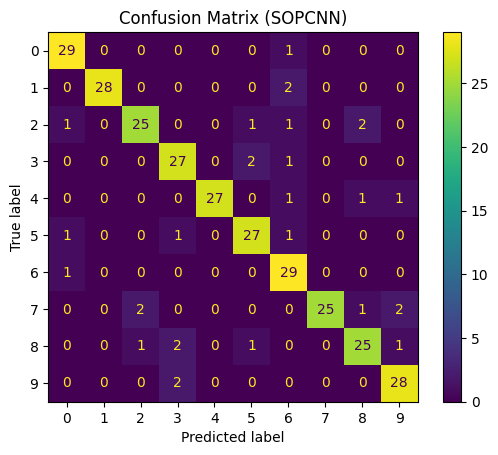

examplecnn.pt Model Architecture:
ExampleCNN(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

examplecnn.pt Model Evaluation:
Accuracy: 0.9

Hyperparameters:
Learning Rate: 0.001
Batch Size: 256
Number of Epochs: 1000


In [12]:
evaluate(smolcnn_model, smolcnn_model_name, test_loader, learning_rate, batch_size, num_epochs)

# Naive Example CNN Write Up

Using this model, I chose a popular learning rate because the dataset is so small and it's a common starting point, ensuring smooth convergence and stable updates. The batch size is good as it Balances computational efficiency and gradient stability. (considering there is only 500 images in the training set). Early stopping patience is set to 10 so it can stop training based on the validation loss to avoid overtraining the model. 

# Alex Net Architecture

In [13]:
# Pre-trained AlexNet structure
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 26),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 3 * 3)
        x = self.classifier(x)
        return x

# Transfer Learning Architectures

In [14]:
alex_model = AlexNet().to(device)
alex_model.load_state_dict(torch.load('pytorch/AlexNet_pretrained.pt', map_location=device, weights_only=True))

# freeze the layers
for param in alex_model.parameters():
    param.requires_grad = False

class AdaptiveScalingLayer(nn.Module):
    def __init__(self, num_channels, init_value=10):
        super(AdaptiveScalingLayer, self).__init__()
        # Initialize gamma as a learnable parameter for each channel
        self.gamma = nn.Parameter(torch.ones(num_channels) * init_value)
        
    def forward(self, x):
        # Compute L2 norm over spatial dimensions
        x_normalized = torch.nn.functional.normalize(x, p=2, dim=1)
        # Scale normalized activations by gamma
        out = self.gamma * x_normalized
        return out

class DepthAugmentedAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(DepthAugmentedAlexNet, self).__init__()
        
        self.features = alex_model.features
        
        # New classifier with increased depth
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),  # Added layer
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 1024),  # Added layer
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),  # Output layer
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class WidthAugmentedAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(WidthAugmentedAlexNet, self).__init__()
        self.features = alex_model.features
        
        # New classifier with increased width
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 8192),  # Increased neurons
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(8192, 8192),  # Increased neurons
            nn.ReLU(inplace=True),
            nn.Linear(8192, num_classes),  # Output layer
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
class DepthWidthAugmentedAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(DepthWidthAugmentedAlexNet, self).__init__()
        self.features = alex_model.features
        
        # New classifier with increased depth and width
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 3 * 3, 8192),  # Increased neurons
            nn.ReLU(inplace=True),
            AdaptiveScalingLayer(8192),  # Added layer
            nn.Linear(8192, 4096),  # Decreased neurons
            nn.ReLU(inplace=True),
            AdaptiveScalingLayer(4096),  # Added layer
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            AdaptiveScalingLayer(2048),  # Added layer
            nn.Linear(2048, num_classes),  # Output layer
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
# create model and hyperparams
d_alex_net = DepthAugmentedAlexNet(num_classes=10).to(device)
d_alex_net_name = f'{d_alex_net._get_name().lower()}.pt'

num_epochs = 1000
learning_rate = 0.001
batch_size = 256

train_loader, val_loader, test_loader = load_data(batch_size)
train(d_alex_net, d_alex_net_name, train_loader, test_loader, num_epochs, learning_rate)

100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


[   0/1000] train_loss: 2.29076 valid_loss: 2.16514
Validation loss decreased (inf --> 2.165141).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 26.86it/s]

[   1/1000] train_loss: 2.05898 valid_loss: 1.48788
Validation loss decreased (2.165141 --> 1.487883).  Saving model ...



100%|██████████| 2/2 [00:00<00:00, 28.33it/s]


[   2/1000] train_loss: 1.32913 valid_loss: 0.89206
Validation loss decreased (1.487883 --> 0.892061).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 28.26it/s]


[   3/1000] train_loss: 0.81240 valid_loss: 0.44782
Validation loss decreased (0.892061 --> 0.447815).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 27.69it/s]


[   4/1000] train_loss: 0.47999 valid_loss: 0.43248
Validation loss decreased (0.447815 --> 0.432484).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 28.28it/s]


[   5/1000] train_loss: 0.38140 valid_loss: 0.37397
Validation loss decreased (0.432484 --> 0.373974).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 28.42it/s]


[   6/1000] train_loss: 0.28809 valid_loss: 0.24400
Validation loss decreased (0.373974 --> 0.244001).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 28.47it/s]


[   7/1000] train_loss: 0.21537 valid_loss: 0.25096
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 25.55it/s]


[   8/1000] train_loss: 0.19846 valid_loss: 0.23656
Validation loss decreased (0.244001 --> 0.236562).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 27.74it/s]


[   9/1000] train_loss: 0.20615 valid_loss: 0.18293
Validation loss decreased (0.236562 --> 0.182927).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 27.75it/s]


[  10/1000] train_loss: 0.11981 valid_loss: 0.19612
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 27.75it/s]


[  11/1000] train_loss: 0.09110 valid_loss: 0.16117
Validation loss decreased (0.182927 --> 0.161170).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 25.37it/s]


[  12/1000] train_loss: 0.10758 valid_loss: 0.15100
Validation loss decreased (0.161170 --> 0.151001).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 25.86it/s]


[  13/1000] train_loss: 0.09118 valid_loss: 0.13416
Validation loss decreased (0.151001 --> 0.134157).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 26.36it/s]


[  14/1000] train_loss: 0.07930 valid_loss: 0.15171
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 27.07it/s]


[  15/1000] train_loss: 0.07101 valid_loss: 0.16910
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 24.22it/s]


[  16/1000] train_loss: 0.08205 valid_loss: 0.17239
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 23.67it/s]


[  17/1000] train_loss: 0.09408 valid_loss: 0.21540
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 25.81it/s]


[  18/1000] train_loss: 0.08277 valid_loss: 0.18588
EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 27.94it/s]


[  19/1000] train_loss: 0.07363 valid_loss: 0.16612
EarlyStopping counter: 6 out of 10


100%|██████████| 2/2 [00:00<00:00, 24.14it/s]


[  20/1000] train_loss: 0.06331 valid_loss: 0.15800
EarlyStopping counter: 7 out of 10


100%|██████████| 2/2 [00:00<00:00, 24.74it/s]


[  21/1000] train_loss: 0.04851 valid_loss: 0.15047
EarlyStopping counter: 8 out of 10


100%|██████████| 2/2 [00:00<00:00, 25.17it/s]


[  22/1000] train_loss: 0.06209 valid_loss: 0.15668
EarlyStopping counter: 9 out of 10


100%|██████████| 2/2 [00:00<00:00, 25.99it/s]


[  23/1000] train_loss: 0.03303 valid_loss: 0.20830
EarlyStopping counter: 10 out of 10
Early stopping!


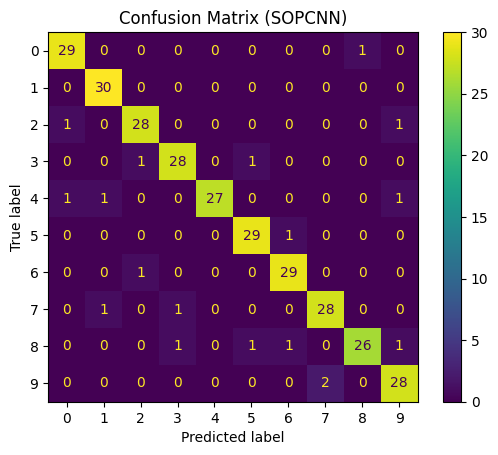

depthaugmentedalexnet.pt Model Architecture:
DepthAugmentedAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=4096, bias=T

In [16]:
evaluate(d_alex_net, d_alex_net_name, test_loader, learning_rate, batch_size, num_epochs)

In [19]:
# create model and hyperparams
w_alex_net = WidthAugmentedAlexNet(num_classes=10).to(device)
w_alex_net_name = f'{w_alex_net._get_name().lower()}.pt'

num_epochs = 1000
learning_rate = 0.001
batch_size = 256

train_loader, val_loader, test_loader = load_data(batch_size)
train(w_alex_net, w_alex_net_name, train_loader, test_loader, num_epochs, learning_rate)

100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


[   0/1000] train_loss: 2.19597 valid_loss: 1.51692
Validation loss decreased (inf --> 1.516925).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


[   1/1000] train_loss: 1.23640 valid_loss: 0.65438
Validation loss decreased (1.516925 --> 0.654381).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.41it/s]


[   2/1000] train_loss: 0.61052 valid_loss: 0.56533
Validation loss decreased (0.654381 --> 0.565334).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.25it/s]


[   3/1000] train_loss: 0.51042 valid_loss: 0.37444
Validation loss decreased (0.565334 --> 0.374437).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


[   4/1000] train_loss: 0.42769 valid_loss: 0.24431
Validation loss decreased (0.374437 --> 0.244305).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


[   5/1000] train_loss: 0.25589 valid_loss: 0.33308
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.85it/s]


[   6/1000] train_loss: 0.21171 valid_loss: 0.28373
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


[   7/1000] train_loss: 0.16105 valid_loss: 0.21252
Validation loss decreased (0.244305 --> 0.212517).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


[   8/1000] train_loss: 0.13607 valid_loss: 0.22070
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


[   9/1000] train_loss: 0.11154 valid_loss: 0.30121
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


[  10/1000] train_loss: 0.15050 valid_loss: 0.26000
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.22it/s]


[  11/1000] train_loss: 0.11771 valid_loss: 0.18901
Validation loss decreased (0.212517 --> 0.189009).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


[  12/1000] train_loss: 0.03719 valid_loss: 0.16779
Validation loss decreased (0.189009 --> 0.167787).  Saving model ...


100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


[  13/1000] train_loss: 0.06676 valid_loss: 0.17384
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


[  14/1000] train_loss: 0.11874 valid_loss: 0.20626
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


[  15/1000] train_loss: 0.06390 valid_loss: 0.28746
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


[  16/1000] train_loss: 0.04240 valid_loss: 0.32109
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


[  17/1000] train_loss: 0.07108 valid_loss: 0.26958
EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


[  18/1000] train_loss: 0.04062 valid_loss: 0.19528
EarlyStopping counter: 6 out of 10


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


[  19/1000] train_loss: 0.03451 valid_loss: 0.17733
EarlyStopping counter: 7 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


[  20/1000] train_loss: 0.05760 valid_loss: 0.17480
EarlyStopping counter: 8 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


[  21/1000] train_loss: 0.04676 valid_loss: 0.20454
EarlyStopping counter: 9 out of 10


100%|██████████| 2/2 [00:00<00:00,  9.82it/s]

[  22/1000] train_loss: 0.05139 valid_loss: 0.24858
EarlyStopping counter: 10 out of 10
Early stopping!


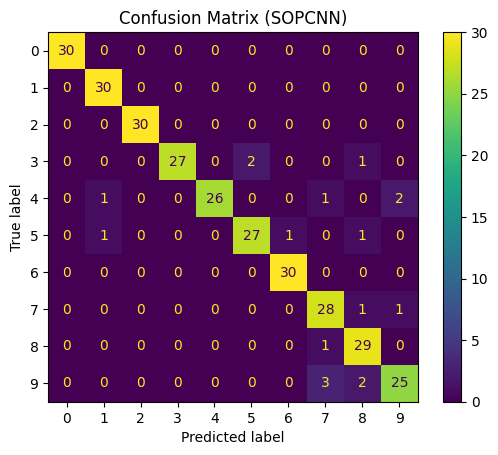

widthaugmentedalexnet.pt Model Architecture:
WidthAugmentedAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=8192, bias=T

In [20]:
evaluate(w_alex_net, w_alex_net_name, test_loader, learning_rate, batch_size, num_epochs)

In [21]:
# width and depth augmented model
dw_alex_net = DepthWidthAugmentedAlexNet(num_classes=10).to(device)
dw_alex_net_name = f'{dw_alex_net._get_name().lower()}.pt'

num_epochs = 1000
learning_rate = 0.001
batch_size = 256

train_loader, val_loader, test_loader = load_data(batch_size)
train(dw_alex_net, dw_alex_net_name, train_loader, test_loader, num_epochs, learning_rate)

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]


[   0/1000] train_loss: 2.25074 valid_loss: 2.14553
Validation loss decreased (inf --> 2.145534).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.34it/s]


[   1/1000] train_loss: 2.02248 valid_loss: 1.31211
Validation loss decreased (2.145534 --> 1.312108).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.02it/s]


[   2/1000] train_loss: 1.27855 valid_loss: 0.81431
Validation loss decreased (1.312108 --> 0.814311).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 12.55it/s]


[   3/1000] train_loss: 0.80783 valid_loss: 0.55841
Validation loss decreased (0.814311 --> 0.558407).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.08it/s]


[   4/1000] train_loss: 0.57254 valid_loss: 0.39142
Validation loss decreased (0.558407 --> 0.391423).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


[   5/1000] train_loss: 0.39650 valid_loss: 0.29743
Validation loss decreased (0.391423 --> 0.297434).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


[   6/1000] train_loss: 0.29061 valid_loss: 0.24593
Validation loss decreased (0.297434 --> 0.245930).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 12.78it/s]


[   7/1000] train_loss: 0.20274 valid_loss: 0.23120
Validation loss decreased (0.245930 --> 0.231196).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.11it/s]


[   8/1000] train_loss: 0.14722 valid_loss: 0.20453
Validation loss decreased (0.231196 --> 0.204533).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


[   9/1000] train_loss: 0.13040 valid_loss: 0.21170
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.14it/s]


[  10/1000] train_loss: 0.10140 valid_loss: 0.23511
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.05it/s]


[  11/1000] train_loss: 0.07682 valid_loss: 0.22945
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.03it/s]


[  12/1000] train_loss: 0.08278 valid_loss: 0.22027
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 11.99it/s]


[  13/1000] train_loss: 0.08113 valid_loss: 0.23501
EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.37it/s]


[  14/1000] train_loss: 0.06784 valid_loss: 0.22137
EarlyStopping counter: 6 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


[  15/1000] train_loss: 0.04023 valid_loss: 0.21245
EarlyStopping counter: 7 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.04it/s]


[  16/1000] train_loss: 0.05111 valid_loss: 0.21755
EarlyStopping counter: 8 out of 10


100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


[  17/1000] train_loss: 0.07136 valid_loss: 0.19826
Validation loss decreased (0.204533 --> 0.198257).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 11.91it/s]


[  18/1000] train_loss: 0.07849 valid_loss: 0.15333
Validation loss decreased (0.198257 --> 0.153327).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 12.20it/s]


[  19/1000] train_loss: 0.05756 valid_loss: 0.21646
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.14it/s]


[  20/1000] train_loss: 0.04941 valid_loss: 0.22455
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.16it/s]


[  21/1000] train_loss: 0.02784 valid_loss: 0.17321
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.67it/s]


[  22/1000] train_loss: 0.04801 valid_loss: 0.19259
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.09it/s]


[  23/1000] train_loss: 0.03827 valid_loss: 0.19897
EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


[  24/1000] train_loss: 0.05423 valid_loss: 0.14719
Validation loss decreased (0.153327 --> 0.147191).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.12it/s]


[  25/1000] train_loss: 0.01920 valid_loss: 0.13740
Validation loss decreased (0.147191 --> 0.137395).  Saving model ...


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


[  26/1000] train_loss: 0.03773 valid_loss: 0.17562
EarlyStopping counter: 1 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.39it/s]


[  27/1000] train_loss: 0.07031 valid_loss: 0.21436
EarlyStopping counter: 2 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


[  28/1000] train_loss: 0.03864 valid_loss: 0.16819
EarlyStopping counter: 3 out of 10


100%|██████████| 2/2 [00:00<00:00, 11.99it/s]


[  29/1000] train_loss: 0.03307 valid_loss: 0.14032
EarlyStopping counter: 4 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.10it/s]

[  30/1000] train_loss: 0.02624 valid_loss: 0.17431


EarlyStopping counter: 5 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.12it/s]


[  31/1000] train_loss: 0.04054 valid_loss: 0.19017
EarlyStopping counter: 6 out of 10


100%|██████████| 2/2 [00:00<00:00, 12.64it/s]


[  32/1000] train_loss: 0.02061 valid_loss: 0.22821
EarlyStopping counter: 7 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.49it/s]


[  33/1000] train_loss: 0.03231 valid_loss: 0.20556
EarlyStopping counter: 8 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.26it/s]


[  34/1000] train_loss: 0.01454 valid_loss: 0.17821
EarlyStopping counter: 9 out of 10


100%|██████████| 2/2 [00:00<00:00, 13.30it/s]


[  35/1000] train_loss: 0.03122 valid_loss: 0.16850
EarlyStopping counter: 10 out of 10
Early stopping!


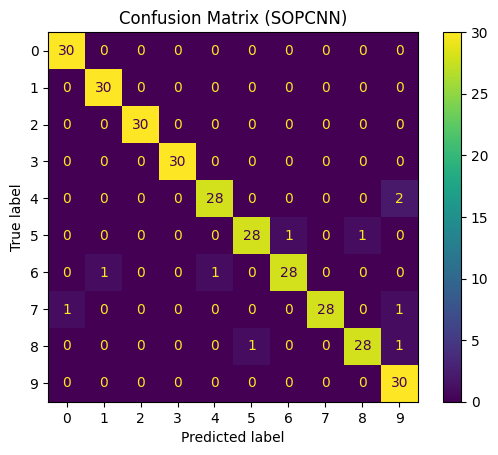

depthwidthaugmentedalexnet.pt Model Architecture:
DepthWidthAugmentedAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=2304, out_features=81

In [22]:
evaluate(dw_alex_net, dw_alex_net_name, test_loader, learning_rate, batch_size, num_epochs)